In [147]:
############ INPUT FILES  ##############

building_id = 1

buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/1/'



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [148]:
########### OUTPUT FILES ###############

# EnergyPlus
output_dir = 'energy_plus/output_energy_plus'
error_dir  = 'energy_plus/output_energy_plus'
# EHUB
res_file   = 'ehub/output_ehub_excel/' + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"

# panel price 400, 200, 106
ga_400_file = ga_output_dir + "panel_400_dual.xlsx"
ga_400_proc = ga_output_dir + "panel_400_dual_processed.xlsx"

ga_200_file = ga_output_dir + "panel_200_dual.xlsx"
ga_200_proc = ga_output_dir + "panel_200_dual_processed.xlsx"

ga_106_file = ga_output_dir + "panel_106_dual.xlsx"
ga_106_proc = ga_output_dir + "panel_106_dual_processed.xlsx"

# panel price 400, 200, 106
ga_400_file_s = ga_output_dir + "panel_400_sing.xlsx"
ga_400_proc_s = ga_output_dir + "panel_400_sing_processed.xlsx"

ga_200_file_s = ga_output_dir + "panel_200_sing.xlsx"
ga_200_proc_s = ga_output_dir + "panel_200_sing_processed.xlsx"

ga_106_file_s = ga_output_dir + "panel_106_sing.xlsx"
ga_106_proc_s = ga_output_dir + "panel_106_sing_processed.xlsx"

In [149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [151]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [152]:
pvbuilding.North_Axis

0.0

In [153]:
pvbuilding.Building_Information


Building,
    Ref Bldg Medium Office New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [154]:
# Determine the hourly electricity use
pvbuilding.run_ep()

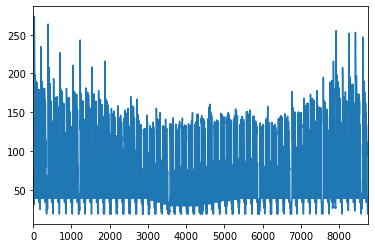

In [155]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [156]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 1,661 m²
Roof area is up 33 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [157]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

numpy.ndarray

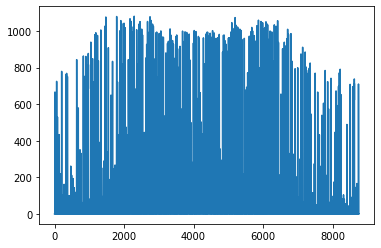

In [158]:
irr = pvpanel.irradiance(180,45,0.6)
plt.plot(irr);
type(irr)

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


In [159]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [5,55,10,35,5]
    gcr = [0.9,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [5,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)
print(pan_vals)
# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

[180, 215, 245, 5, 55, 10, 0.9, 0.35, 0.9]
Loading the model
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
Start Evaluation
Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 5.0
                                           and a gcr of 0.900
Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 55.0
                                           and a gcr of 0.350
Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 10.0
                                           and a gcr of 0.900
Generated the panel irradiance in   0s
Starting recompile
R

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 /year


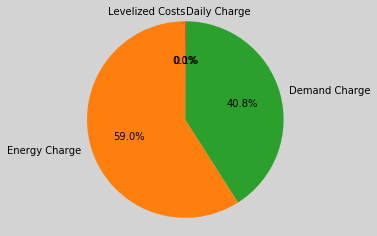

In [160]:
my_model.make_pie_chart()

In [161]:
my_model.costBreak

{'Levelized Costs': 0.08550000000873581,
 'Energy Charge': 42154.6,
 'Demand Charge': 29169.85,
 'Daily Charge': 97.5645}

In [162]:
my_model.generated_percentage()

Total Electricity Load from the building: 695,621 kWh
Total Electricity Generated from PV: 0 kWh
Percentage: 0.0%


In [163]:
my_model.roof_percentage()

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%


In [164]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    29169.85
dtype: float64

In [165]:
print(my_model.solveResults['solution']['energy_exported']['GreenElec'].sum())
print(my_model.solveResults['solution']['energy_imported'].max())

print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['total_import'])
print(my_model.solveResults['solution']['total_import_cost'])
print(my_model.solveResults['solution']['total_export_income'])

0.0
Grid    273.772
dtype: float64
0.0
695621.0
42154.6
0.0


In [166]:
print(my_model.solveResults['solution']['max_energy_billing'])
print(my_model.solveResults['solution']['max_energy_billing'].sum())

print(my_model.solveResults['solution']['above_550'])
print(my_model.solveResults['solution']['above_35'])
print(my_model.solveResults['solution']['above_150'])

     max_energy_billing
Apr             170.135
Aug             154.153
Dec             252.933
Feb             243.145
Jan             273.772
Jul             160.309
Jun             149.240
Mar             215.852
May             155.102
Nov             255.156
Oct             176.701
Sep             157.348
max_energy_billing    2363.846
dtype: float64
1
     above_35
Apr         1
Aug         1
Dec         1
Feb         1
Jan         1
Jul         1
Jun         1
Mar         1
May         1
Nov         1
Oct         1
Sep         1
     above_150
Apr          0
Aug          0
Dec          1
Feb          0
Jan          1
Jul          0
Jun          0
Mar          0
May          0
Nov          1
Oct          0
Sep          0


In [167]:
my_model.solveResults['solution']['any_above_35']

1

In [168]:
my_model.solveResults['solution']['above_550']

1

In [169]:
my_model.solveResults['solution']['any_above_150']

1

In [170]:
my_model.solveResults['solution']['a150_or_a550']

1

# (D) GA - Optimize the model

In [ ]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

## Run a panel price of 400

### Multi objective Minimize cost Maximize Installed Capacity

In [ ]:
price = 400

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_400_file,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_400_proc)

### Single objective Minimize cost

In [ ]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_400_file_s,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","SINGLE")
pvoptimizer.processGA(ga_400_proc_s)

## Run a panel price of 200

### Multi objective Minimize cost Maximize Installed Capacity

In [ ]:
price = 200

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_200_file,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_200_proc)

### Single objective Minimize cost

In [ ]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_200_file_s,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","SINGLE")
pvoptimizer.processGA(ga_200_proc_s)

## Run a panel price of 106

### Multi objective Minimize cost Maximize Installed Capacity

In [ ]:
price = 106
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_106_file,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_106_proc)

### Single objective Minimize cost

In [ ]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_106_file_s,
                 ehub_file=ehub_file,
                 roof_area=pvbuilding.roof_area,
                 res_file=res_file,
                 hourly_electricity=pvbuilding.hourly_electricity,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","SINGLE")
pvoptimizer.processGA(ga_106_proc_s)